In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

from pandas.io.json import json_normalize
import json

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

import folium

import itertools

# Exploring Dataset

## Sales

In [2]:
sales = pd.read_csv('..\UseCase_3_Datasets\sales_granular.csv')
sales.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Store code should be unique

In [3]:
sales.store_code.is_unique

False

In [4]:
for index, boolean in enumerate(sales.store_code.duplicated()):
    if boolean: print index

33
34
35


In [5]:
# inspect duplicate
sales.loc[sales.store_code == sales.store_code[33]]

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
32,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
33,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
34,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
35,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN


It seems that the 11028th POS entries have been duplicated

In [6]:
sales.drop_duplicates('store_code', inplace=True, keep='first')

In [7]:
sales.store_code.is_unique

True

# Performance Measure
We want to maximize sales and so we need to determine what is a good measure to separate good POS from bad and average POS

In [8]:
sales.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
sales= sales.set_index('store_code').T.copy().fillna(0)
sales.index = sales.index.to_datetime()
sales.head()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384,...,84089,84125,84128,84146,84219,84223,84351,84608,84658,85011
2015-08-03 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-03 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,600.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-03 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-03 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-03 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## TimeFrame

In [10]:
sales = sales.resample('W')

In [11]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

In [12]:
# Create traces
trace0 = go.Scatter(
    y = sales.T.iloc[0],
    x = np.arange(0,len(sales)),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace1 = go.Scatter(
    y = sales.T.iloc[201],
    x = np.arange(0,len(sales)),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace2 = go.Scatter(
    y = sales.T.iloc[800],
    x = np.arange(0, len(sales)),
    mode = 'lines+markers',
    name = 'lines+markers'
)

raw_data = [trace0, trace1, trace2]

layout = go.Layout(title='Raw time series', showlegend=True)
fig = go.Figure(data=raw_data, layout=layout)

iplot(fig, filename='show-legend')

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:


.resample() is now a deferred operation
You called T(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:


.resample() is now a deferred operation
You called T(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: FutureWarning:


.resample() is now a deferred operation
You called T(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead



We might imagine that there is a seeasonality in the sales volumne. To be sure, we need to inspect the fft of the time serie.

In [13]:
#sales = sales.resample('W')
sales = (sales - (sales.shift(periods=1, axis=0).fillna(0)))
sales.head()

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:


.resample() is now a deferred operation
You called shift(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:


.resample() is now a deferred operation
You called __sub__(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead



store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384,...,84089,84125,84128,84146,84219,84223,84351,84608,84658,85011
2015-08-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,43.483146,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-6.424323,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,32.414861,0.0,0.0,0.0,0.0,0.0,0.0
2015-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,35.832438,0.0,0.0,0.0,0.0,0.0,0.0
2015-09-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-33.127905,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
sales= sales.T
sales.head()

,2015-08-09 00:00:00,2015-08-16 00:00:00,2015-08-23 00:00:00,2015-08-30 00:00:00,2015-09-06 00:00:00,2015-09-13 00:00:00,2015-09-20 00:00:00,2015-09-27 00:00:00,2015-10-04 00:00:00,2015-10-11 00:00:00,...,2017-04-23 00:00:00,2017-04-30 00:00:00,2017-05-07 00:00:00,2017-05-14 00:00:00,2017-05-21 00:00:00,2017-05-28 00:00:00,2017-06-04 00:00:00,2017-06-11 00:00:00,2017-06-18 00:00:00,2017-06-25 00:00:00
store_code,,,,,,,,,,,,,,,,,,,,,
10055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.351017,1.797040,-1.573427,2.255245,-0.100267,4.079236,-6.701037,2.290076,3.467345,0.425785
10077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,5.227273,-4.304196,-0.241259,-0.020053,-0.437884,-0.223881,4.809160,-2.809160,6.015267
10079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-28.315770,14.445032,10.520979,-23.930070,16.016043,-0.948200,-8.003304,-7.557252,-0.072943,0.759966
10081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,21.028343,16.627907,-24.538462,0.447552,-3.335561,41.381694,-38.039193,-9.847328,-4.624258,18.364716
10085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.347020,-4.645877,5.227273,2.500000,-3.382353,-1.804214,4.633132,-5.038168,-3.686175,-0.206955


In [15]:
sales_perf = (sales.sum(axis=1)/(sales != 0).sum(axis=1)).to_frame()
sales_perf.columns = ['Mean_Perf']

In [16]:
sales_perf['Median_Perf'] = sales[sales!=0].median(axis=1)

In [17]:
import plotly.graph_objs as go
df = sales_perf.Mean_Perf.sort_values()

data = [go.Bar(
            y=df.values,
            x=np.arange(len(df))
    )]

iplot(data, filename='basic-bar')

In [18]:
df = sales_perf.Median_Perf.sort_values()

data = [go.Bar(
            y=df.values,
            x=np.arange(len(df))
    )]

iplot(data, filename='basic-bar')

The median creates a good separation between good, average and bad POS. Indeed, the median is outlier resistant and the examination of the sales' time serie revealed the presence of outliers in the dataset.

# Grouping POS On Performance

In [19]:
def group_perfs(x):
    if x < 0 :
        return -1
    elif x > 0.25 :
        return 1
    return 0

sales_perf['Performance'] = sales_perf.Median_Perf.apply(group_perfs)
sales_perf.head()

,Mean_Perf,Median_Perf,Performance
store_code,,,
10055,0.112627,0.833333,1
10077,0.381679,-0.032468,-1
10079,0.400763,0.414787,1
10081,1.012643,-0.997158,-1
10085,0.258557,-0.206955,-1


In [20]:
sales_perf.Performance.value_counts()

 0    391
-1    268
 1    244
Name: Performance, dtype: int64

# Surroundings

In [21]:
d = json.load(open('..\UseCase_3_Datasets\Surroundings.json'))

In [22]:
surroundings = json_normalize(d)

In [23]:
surroundings.set_index('store_code', inplace=True)
surroundings.head()

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.store,surroundings.subway_station,surroundings.synagogue,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo
store_code,,,,,,,,,,,,,,,,,,,,,
10055,[{u'name': u'Fiduciaire Exacte & Gestion Compt...,[],[],[],"[{u'website': u'http://www.onegeeinfog.com/', ...",[{u'website': u'https://www.ubs.com/ch/fr.html...,"[{u'name': u'Mconseils SA', u'place_id': u'ChI...","[{u'website': u'http://www.ubs.ch/', u'rating'...","[{u'rating': 3.5, u'place_id': u'ChIJ8xHdm_1vj...","[{u'website': u'http://www.jadebeaute.com/', u...",...,[{u'website': u'https://filialen.migros.ch/de/...,[],[],[],[],"[{u'name': u'Chêne-Bourg, La Mousse', u'place_...","[{u'name': u'Courir au Népal Sàrl', u'place_id...",[],[{u'website': u'http://www.vet-chene-bougeries...,[]
10077,[],[],[],[],[],[],"[{u'rating': 4.8, u'place_id': u'ChIJM8FbQe9vj...",[],[],[],...,[{u'website': u'http://www.coop.ch/fr/services...,[],[],[],[],"[{u'name': u'Chêne-Bougeries, Montagne', u'pla...",[],[],[],[]
10079,[{u'website': u'http://www.vd.ch/autorites/dep...,[],[],[],[],"[{u'name': u'PickPost-Stelle', u'opening_hours...",[{u'website': u'https://filialen.migros.ch/de/...,[{u'website': u'https://www.ubs.com/ch/fr.html...,[{u'website': u'https://www.facebook.com/Highl...,"[{u'rating': 5, u'place_id': u'ChIJmxg6U4LPjUc...",...,"[{u'website': u'http://www.denner.ch/', u'rati...",[],[],[],[],"[{u'name': u'Yverdon-les-Bains, Bel-Air', u'pl...","[{u'website': u'http://www.hotelplan.ch/FR/', ...",[],[],[]
10086,[],[],[],[],[],[],[],[],"[{u'website': u'http://www.oubangui.com/', u'r...",[{u'website': u'http://www.blattnerpodologue.c...,...,"[{u'rating': 3.3, u'place_id': u'ChIJUW-HLeAxj...",[],[],[],[],"[{u'name': u'Bois-Gentil', u'place_id': u'ChIJ...",[],[],[],[]
10111,[],[],[],[],[],[],[],[],[],[],...,"[{u'name': u'lookemontre.com', u'opening_hours...",[],[],[],[],"[{u'name': u'Yverdon-les-Bains, Plaisance', u'...",[],[],[],[]


#### Store code should be unique

In [24]:
surroundings.index.is_unique

False

In [25]:
for index, boolean in enumerate(surroundings.index.duplicated()):
    if boolean: print index

21


In [26]:
surroundings.iloc[21].name

11028

In [27]:
for index, shopCode in enumerate(surroundings.index):
    if shopCode == 11028:
        print surroundings

                                      surroundings.accounting  \
store_code                                                      
10055       [{u'name': u'Fiduciaire Exacte & Gestion Compt...   
10077                                                      []   
10079       [{u'website': u'http://www.vd.ch/autorites/dep...   
10086                                                      []   
10111                                                      []   
10377       [{u'website': u'http://www.cgiconseils.ch/', u...   
10441       [{u'website': u'https://www.jffiduciaire.ch/',...   
10545       [{u'website': u'http://www.fiva.ch/', u'name':...   
10548       [{u'website': u'http://www.fiva.ch/', u'name':...   
10672                                                      []   
10814                                                      []   
10820                                                      []   
10871                                                      []   
10883       [{u'website':

                                      surroundings.accounting  \
store_code                                                      
10055       [{u'name': u'Fiduciaire Exacte & Gestion Compt...   
10077                                                      []   
10079       [{u'website': u'http://www.vd.ch/autorites/dep...   
10086                                                      []   
10111                                                      []   
10377       [{u'website': u'http://www.cgiconseils.ch/', u...   
10441       [{u'website': u'https://www.jffiduciaire.ch/',...   
10545       [{u'website': u'http://www.fiva.ch/', u'name':...   
10548       [{u'website': u'http://www.fiva.ch/', u'name':...   
10672                                                      []   
10814                                                      []   
10820                                                      []   
10871                                                      []   
10883       [{u'website':

No way to guess which of the information is correct, so we will delete the row 21

In [28]:
surroundings.drop(surroundings.index[21], inplace=True)
surroundings.index.is_unique

True

#### Delete POS with no surrounding information

In [29]:
count = surroundings.applymap(len).copy()
count.head()

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.store,surroundings.subway_station,surroundings.synagogue,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo
store_code,,,,,,,,,,,,,,,,,,,,,
10055,3,0,0,0,1,1,3,3,1,4,...,31,0,0,0,0,2,1,0,1,0
10077,0,0,0,0,0,0,1,0,0,0,...,6,0,0,0,0,1,0,0,0,0
10079,1,0,0,0,0,3,3,1,4,4,...,53,0,0,0,0,4,2,0,0,0
10086,0,0,0,0,0,0,0,0,1,2,...,3,0,0,0,0,1,0,0,0,0
10111,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,4,0,0,0,0


In [30]:
count.shape

(544, 89)

In [31]:
count = count.loc[:, (count != 0).any(axis=0)]
count.shape

(544, 87)

In [32]:
count['summation'] = count.sum(axis=1)
count.summation[count.summation == 0]

store_code
29703    0
30151    0
30348    0
30478    0
30991    0
31270    0
31983    0
32418    0
Name: summation, dtype: int64

In [33]:
count = count[count.summation != 0]

In [34]:
information = set()
latitudes = []
longitudes = []

for pos, countings in count.iterrows():
    column = countings.nonzero()[0][0]
    latitudes.append(json_normalize(surroundings[surroundings.columns[column]][pos]).latitude[0])
    longitudes.append(json_normalize(surroundings[surroundings.columns[column]][pos]).longitude[0])

In [35]:
count['latitude'] = latitudes
count['longitude'] = longitudes

In [36]:
count.head()

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude
store_code,,,,,,,,,,,,,,,,,,,,,
10055,3,0,0,0,1,1,3,3,1,4,...,0,0,2,1,0,1,0,168,46.195035,6.192835
10077,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,18,46.205011,6.201729
10079,1,0,0,0,0,3,3,1,4,4,...,0,0,4,2,0,0,0,191,46.779259,6.635920
10086,0,0,0,0,0,0,0,0,1,2,...,0,0,1,0,0,0,0,25,46.540611,6.620909
10111,0,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,23,46.769927,6.649702


#### POS competition ?
I thought about include a feature to describe if a POS is close to another, as it might trigger competion between them and impact sales negatively

In [37]:
distance = []
for lat, lon in zip(count.latitude, count.longitude):
    distance = distance + np.trim_zeros(np.sqrt((count.latitude - lat)**2 + (count.longitude - lon)**2)[1:]).tolist()

In [38]:
close = []
for n in np.arange(0, len(distance), 535):
    d = np.trim_zeros(distance[n:n+535])
    d = np.asarray(d)
    if d[d.nonzero()].min() < 0.009:
        close.append(True)
    else:
        close.append(False)

In [39]:
count['close_POS'] = close

In [40]:
count[count.close_POS == True]

,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,surroundings.beauty_salon,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10377,2,0,0,0,18,4,12,29,27,14,...,0,2,14,1,0,0,613,46.202925,6.145632,True
10441,1,0,0,0,3,1,6,3,12,16,...,1,7,9,2,0,0,414,46.523979,6.625411,True
10545,1,0,0,0,0,2,4,4,1,7,...,1,4,3,0,0,0,276,46.227472,7.358535,True
10548,1,0,0,0,0,2,5,4,1,7,...,0,2,3,0,0,0,263,46.227472,7.358535,True
10814,0,0,0,0,1,0,0,0,1,0,...,0,3,1,0,0,0,32,46.517927,6.606993,True
10820,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,39,46.519343,6.599406,True
10962,1,0,0,0,0,13,6,11,7,6,...,1,4,10,1,1,0,421,46.802253,7.151657,True
10975,3,0,0,0,0,11,6,13,11,8,...,1,6,5,6,1,0,460,46.803988,7.154988,True
10992,3,0,0,0,5,7,5,8,14,27,...,0,13,12,1,0,0,640,46.990527,6.927767,True


In [41]:
count.to_csv('count')

# Merging surroudings features and performance score

In [42]:
sales_surrounding = sales_perf.join(count, how='inner')
sales_surrounding.head()

,Mean_Perf,Median_Perf,Performance,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10055,0.112627,0.833333,1,3,0,0,0,1,1,3,...,0,2,1,0,1,0,168,46.195035,6.192835,False
10077,0.381679,-0.032468,-1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,18,46.205011,6.201729,False
10079,0.400763,0.414787,1,1,0,0,0,0,3,3,...,0,4,2,0,0,0,191,46.779259,6.635920,False
10086,0.510062,0.716283,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,25,46.540611,6.620909,False
10111,0.822346,0.281858,1,0,0,0,0,0,0,0,...,0,4,0,0,0,0,23,46.769927,6.649702,False


In [43]:
sales_surrounding.drop(['Mean_Perf','Median_Perf'], axis=1, inplace=True)
sales_surrounding.head()

,Performance,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10055,1,3,0,0,0,1,1,3,3,1,...,0,2,1,0,1,0,168,46.195035,6.192835,False
10077,-1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,18,46.205011,6.201729,False
10079,1,1,0,0,0,0,3,3,1,4,...,0,4,2,0,0,0,191,46.779259,6.635920,False
10086,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,25,46.540611,6.620909,False
10111,1,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,23,46.769927,6.649702,False


# Test-Train split

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [45]:
without_0 = sales_surrounding[sales_surrounding.Performance != 0]

In [46]:
X = without_0.drop('Performance', axis=1).values
y =without_0.Performance.values

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4)

## Logistic regression

In [48]:
logi = LogisticRegression()

In [ ]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
                   'class_weight' : ['', 'balanced']}
                   

In [49]:
logi.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Confusion matrix, without normalization
[[35 37]
 [23 20]]


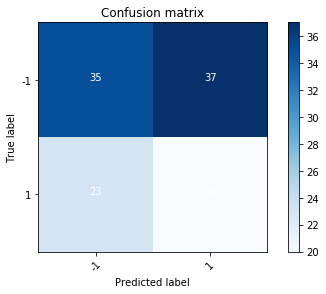

In [50]:
logi_matrix = confusion_matrix(y_test, logi.predict(X_test))
plt.figure()
plot_confusion_matrix(logi_matrix, ('-1','1'))

In [51]:
f1_logistic = cross_val_score(
    logi, X, y, cv=5, scoring='f1')
f1_logistic.mean() 

0.46875832652913241

We can start with a simple model, like SVM for classification

In [52]:
tuned_parameters = {'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000],
                   'class_weight' : ['', 'balanced']}
                   

In [53]:
scores = ['f1']

In [54]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1
()
Best parameters set found on development set:
()
{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001, 'class_weight': ''}
()
Grid scores on development set:
()
0.471 (+/-0.127) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': ''}
0.535 (+/-0.063) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001, 'class_weight': ''}
0.568 (+/-0.118) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001, 'class_weight': 'balanced'}
0.542 (+/-0.048) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.541 (+/-0.180) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'class_weight': ''}
0.543 (+/-0.069) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001, 'class_weight': ''}
0.522 (+/-0.131) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.001, 'class_weight': 'balanced'}
0.525 (+/-0.028) for {'kernel': 'rbf', 'C': 10, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.545 (+/-0.107) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001, 'class_weight': ''}
0.630 (+/-0.083) for {'

In [55]:
svc = SVC(C=100, gamma=0.0001, class_weight = '')
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.63478260869565217

In [56]:
svc_matrix = confusion_matrix(y_test, svc.predict(X_test))
svc_matrix

array([[49, 23],
       [19, 24]], dtype=int64)

Confusion matrix, without normalization
[[49 23]
 [19 24]]


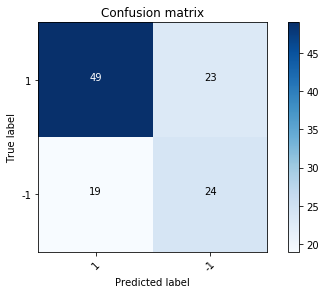

In [57]:
plt.figure()
plot_confusion_matrix(svc_matrix, ('1','-1'))

In [58]:
f1_svc = cross_val_score(
    svc, X, y, cv=5, scoring='f1')
f1_svc.mean()

0.3655509955920353

## Random Forest

In [59]:
tuned_parameters = {'n_estimators': [1, 10, 100, 1000],
                   'class_weight' : [None, 'balanced'],
                   'max_features' :  ['auto', 'log2', 'sqrt']}

In [60]:
for score in ['f1']:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for f1
()
Best parameters set found on development set:
()
{'max_features': 'auto', 'n_estimators': 1000, 'class_weight': None}
()
Grid scores on development set:
()
0.587 (+/-0.142) for {'max_features': 'auto', 'n_estimators': 1, 'class_weight': None}
0.606 (+/-0.107) for {'max_features': 'auto', 'n_estimators': 10, 'class_weight': None}
0.651 (+/-0.111) for {'max_features': 'auto', 'n_estimators': 100, 'class_weight': None}
0.682 (+/-0.094) for {'max_features': 'auto', 'n_estimators': 1000, 'class_weight': None}
0.556 (+/-0.243) for {'max_features': 'log2', 'n_estimators': 1, 'class_weight': None}
0.542 (+/-0.123) for {'max_features': 'log2', 'n_estimators': 10, 'class_weight': None}
0.628 (+/-0.063) for {'max_features': 'log2', 'n_estimators': 100, 'class_weight': None}
0.646 (+/-0.089) for {'max_features': 'log2', 'n_estimators': 1000, 'class_weight': None}
0.502 (+/-0.240) for {'max_features': 'sqrt', 'n_estimators': 1, 'class_weight': None}
0.603 (+/-0.0

In [61]:
forest = RandomForestClassifier(max_features = 'log2',n_estimators=10, n_jobs=-1, class_weight = 'balanced')
forest.fit(X_train, y_train)
forest.score(X_test,y_test)

0.57391304347826089

In [62]:
svc_matrix = confusion_matrix(y_test, forest.predict(X_test))
svc_matrix

array([[57, 15],
       [34,  9]], dtype=int64)

Confusion matrix, without normalization
[[57 15]
 [34  9]]


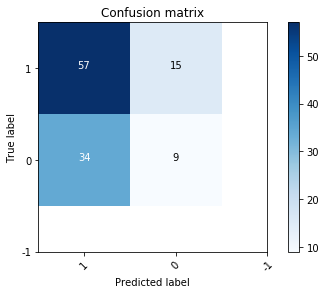

In [63]:
plt.figure()
plot_confusion_matrix(svc_matrix, ('1', '0', '-1'))

In [64]:
f1_forest = cross_val_score(
    forest, X, y, cv=5, scoring='f1')
f1_forest.mean()

0.2934190567935665

In [65]:
importances = forest.feature_importances_

In [66]:
pd.Series(importances, index=without_0.drop('Performance', axis=1).columns).sort_values()[::-1]

longitude                          0.051285
summation                          0.048211
surroundings.travel_agency         0.032472
surroundings.transit_station       0.032337
surroundings.electronics_store     0.031084
surroundings.restaurant            0.029222
surroundings.physiotherapist       0.028836
surroundings.car_repair            0.028377
surroundings.hair_care             0.027712
surroundings.cafe                  0.025821
latitude                           0.025808
surroundings.furniture_store       0.025485
surroundings.real_estate_agency    0.021601
surroundings.clothing_store        0.020034
surroundings.gas_station           0.019672
surroundings.moving_company        0.018008
surroundings.shoe_store            0.017871
surroundings.car_rental            0.017353
surroundings.liquor_store          0.017288
surroundings.art_gallery           0.016170
surroundings.lawyer                0.016061
surroundings.atm                   0.016006
surroundings.car_dealer         

## K nearest neighborgs

In [67]:
knn = KNeighborsClassifier(n_neighbors=1, algorithm='kd_tree', weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance')

In [68]:
knn_matrix = confusion_matrix(y_test, knn.predict(X_test))
knn_matrix

array([[45, 27],
       [19, 24]], dtype=int64)

Confusion matrix, without normalization
[[45 27]
 [19 24]]


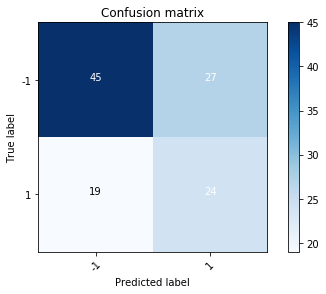

In [69]:
plt.figure()
plot_confusion_matrix(knn_matrix, ('-1', '1'))

In [70]:
f1_knn = cross_val_score(
    knn, X, y, cv=5, scoring='f1')
f1_knn.mean()

0.46221749408983454

In [71]:
knn.score(X_test, y_test)

0.59999999999999998

## ADABoost

In [72]:
AdaBoostClassifier(algorithm='SAMME', base_estimator=None,
          learning_rate=0.1, n_estimators=100, random_state=None).fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME', base_estimator=None, learning_rate=0.1,
          n_estimators=100, random_state=None)

In [73]:
ada = AdaBoostClassifier()
f1_ada = cross_val_score(
    ada, X, y, cv=5, scoring='f1')
f1_ada.mean()

0.41440410740865019

In [74]:
ada.fit(X_train, y_train)
ada_matrix = confusion_matrix(y_test, ada.predict(X_test))
ada_matrix

array([[53, 19],
       [25, 18]], dtype=int64)

Confusion matrix, without normalization
[[53 19]
 [25 18]]


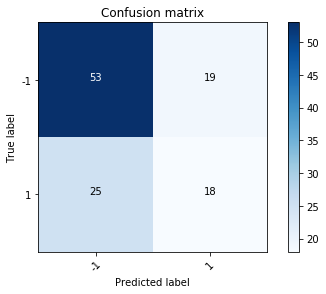

In [75]:
plt.figure()
plot_confusion_matrix(ada_matrix, ('-1', '1'))

In [76]:
corr_mat = sales_surrounding.corr().Performance.to_frame()
corr_mat.columns = ['Correlation']
corr_mat['Correlation_abs'] = abs(corr_mat.Correlation)
corr_mat = corr_mat.sort_values('Correlation_abs', ascending=False).drop('Correlation_abs', axis=1).copy()

In [77]:
corr_mat

,Correlation
Performance,1.000000
longitude,-0.172367
surroundings.department_store,0.157145
surroundings.beauty_salon,0.150690
surroundings.library,0.143002
surroundings.shoe_store,0.142393
surroundings.clothing_store,0.139895
surroundings.laundry,0.137660
surroundings.pharmacy,0.132587
surroundings.meal_takeaway,0.131397


# Visualization

In [78]:
sales_viz = sales_perf.join(count, how='inner')

In [79]:
sales_viz.head()

,Mean_Perf,Median_Perf,Performance,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,...,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo,summation,latitude,longitude,close_POS
store_code,,,,,,,,,,,,,,,,,,,,,
10055,0.112627,0.833333,1,3,0,0,0,1,1,3,...,0,2,1,0,1,0,168,46.195035,6.192835,False
10077,0.381679,-0.032468,-1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,18,46.205011,6.201729,False
10079,0.400763,0.414787,1,1,0,0,0,0,3,3,...,0,4,2,0,0,0,191,46.779259,6.635920,False
10086,0.510062,0.716283,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,25,46.540611,6.620909,False
10111,0.822346,0.281858,1,0,0,0,0,0,0,0,...,0,4,0,0,0,0,23,46.769927,6.649702,False


In [80]:
locations = sales_viz[['latitude', 'longitude']]

In [81]:
locationlist = locations.values.tolist()

In [82]:
map = folium.Map(location=[46.8, 8.0],zoom_start=8)

for point in range(0, len(locationlist)):
    if sales_viz.Performance.iloc[point] == 1:
        folium.Marker(locationlist[point],
                     icon=folium.Icon(color='red', icon='star')).add_to(map)
    elif sales_viz.Performance.iloc[point] == -1:
        folium.Marker(locationlist[point],
                     icon=folium.Icon(color='blue', icon='none')).add_to(map)
    else:
        folium.Marker(locationlist[point],
                     icon=folium.Icon(color='blue', icon='minus')).add_to(map)
    
map